# IEEE Fraud Detection

La détection des fraudes en ligne est l'une des problématiques les plus courantes et sensibles dans de nombreux secteurs, en particulier les banques. Au cours des dernières années, les tentatives de fraude ont connu une forte hausse, ce qui rend la lutte contre ce phénomène très importante. 

Cette compétition est un problème de classification binaire - c'est-à-dire que notre variable cible est un attribut binaire (l'utilisateur fait-il le clic frauduleux ou non?) Et notre objectif est de classer les utilisateurs en "frauduleux" ou "non frauduleux" le mieux possible.

On cherche à prédire la probabilité qu'une transaction en ligne soit frauduleuse.

# Packages nécessaires

In [939]:
import numpy as np     
import pandas as pd   
import matplotlib.pyplot as plt   
import seaborn as sns          #version améliorée de matplotlib
import pickle as pkl
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time
import random
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

sns.set() #pour avoir de plus beau plot

# Import des données

Commençons par vérifier les données submission.

In [940]:
data_sub = pd.read_csv('sample_submission.csv')
data_sub.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [941]:
del data_sub

On charge maintenant, les données trains et tests. Les données sont divisées en deux fichiers d'identité et de transaction

In [942]:
train_id = pd.read_csv('train_identity.csv')
train_trans = pd.read_csv('train_transaction.csv')
test_id = pd.read_csv('test_identity.csv')
test_trans = pd.read_csv('test_transaction.csv')

In [943]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


On rassemble les données train et test via la variable TransactionID.

In [944]:
TransactionID = test_id["TransactionID"]

In [945]:
train = pd.merge(train_trans, train_id, on='TransactionID', how='left')
test = pd.merge(test_trans, test_id, on='TransactionID', how='left')

In [946]:
del train_id, train_trans, test_id, test_trans

 - Réduction de mémoire

In [947]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [948]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to  5.10 Mb (69.3% reduction)
Mem. usage decreased to  5.09 Mb (69.2% reduction)


# Visualisation des données

Tout d'abord, on visualise les données à l'aide de graphiques et de tests statistiques.

**Données "object"**

In [949]:
cat_cols = list(train.select_dtypes(include=['object']).columns)
print(cat_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


 Variables discrètes :

 - ProductCD
 - emaildomain
 - card1 - card6
 - addr1, addr2
 - P_emaildomain
 - R_emaildomain
 - M1 - M9
 - DeviceType
 - DeviceInfo
 - id_12 - id_38

Le reste des variables sont numériques.

***TransactionDT: timedelta from a given reference datetime (not an actual timestamp)*** 

***TransactionAMT : That is transaction amount in USD**

***ProductCD: Product code for each transaction***

***card1 - card6: Information about payment card*** 

***addr: Address for purchaser and recipient***

***addr1 as billing region***

***addr2 as billing country***

***dist: distance ***
***"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc***


***P_ and (R_) emaildomain: Purchaser and recipient email domain ***

***C1-C14: Counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. ***

***D1-D15: Timedelta, such as days between previous transaction, etc. ***

***M1-M9: Match, such as names on card and address, etc.***

***Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.***

***id01-id11 : Numerical features for identity***

***IsFraud =1 means fradulent transaction, otherwise nofradulent transaction.***


## Target : isFraud

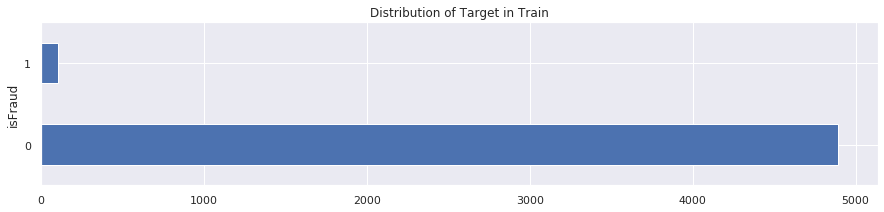

In [950]:
train.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='barh',
          title='Distribution of Target in Train',
          figsize=(15, 3))
plt.show()

On peut voir clairement que la plupart des transactions sont non frauduleuses. Si on utilise cette base de données comme base pour nos modèles prédictifs et nos analyses, nous pourrions obtenir beaucoup d'erreurs et nos algorithmes seront probablement trop adaptés car ils "supposeront" que la plupart des transactions ne sont pas de la fraude. Mais on ne veut pas que notre modèle suppose, nous voulons que notre modèle détecte les modèles qui donnent des signes de fraude!

## Transaction Amt

Cette variable décrit le montant de la transaction.

In [951]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

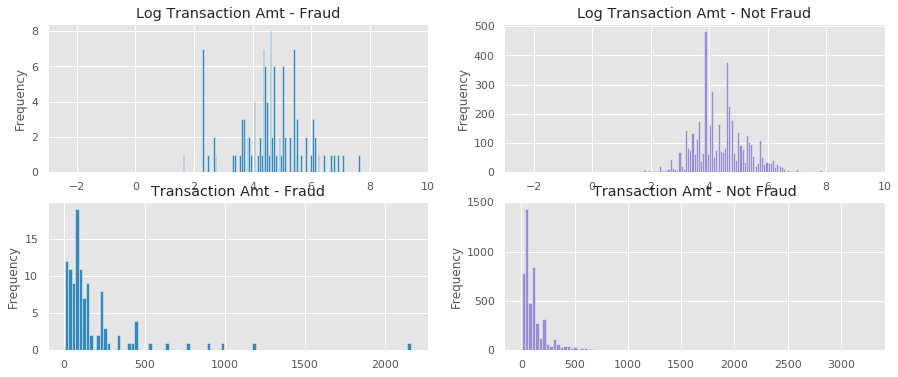

In [952]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax3)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax4)
plt.show()


In [953]:
print('Mean transaction amt for fraud is {:.4f}'.format(train.loc[train['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(train.loc[train['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 182.8750
Mean transaction amt for non-fraud is inf


In [954]:
from scipy import stats
print(stats.ttest_ind(train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] ,train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] ,equal_var=False))

Ttest_indResult(statistic=0.0, pvalue=1.0)


En faisant un test de student on remarque qu'il y a une différence significative entre les deux moyennes.

## ProductCD

Le produit pour chaque transaction.

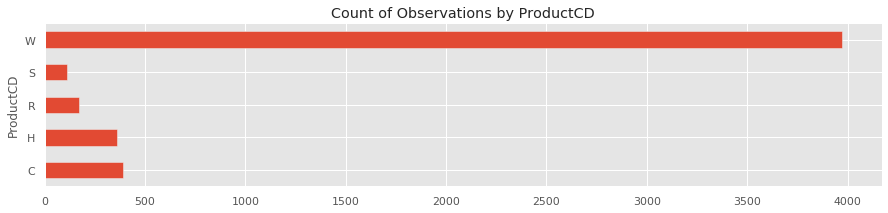

In [955]:
train.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

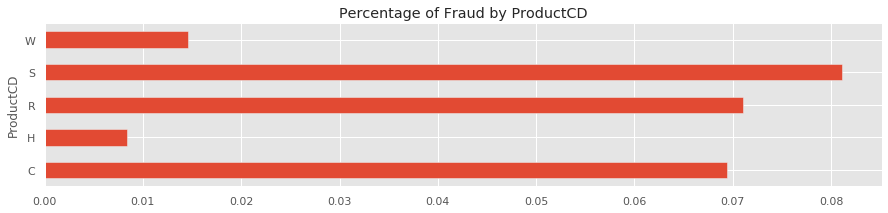

In [956]:
train.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

On observe que :
 - W a le plus grand nombre d'observations, C a le moins.
 - C a le plus grand pourcentage de fraude >11%
 - W a le moins avec ~2%

## card1 - card6

Informations sur les cartes de paiement.

In [957]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [958]:
color_idx = 0
for c in card_cols:
    if train[c].dtype in ['float64','int64']:
        train[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

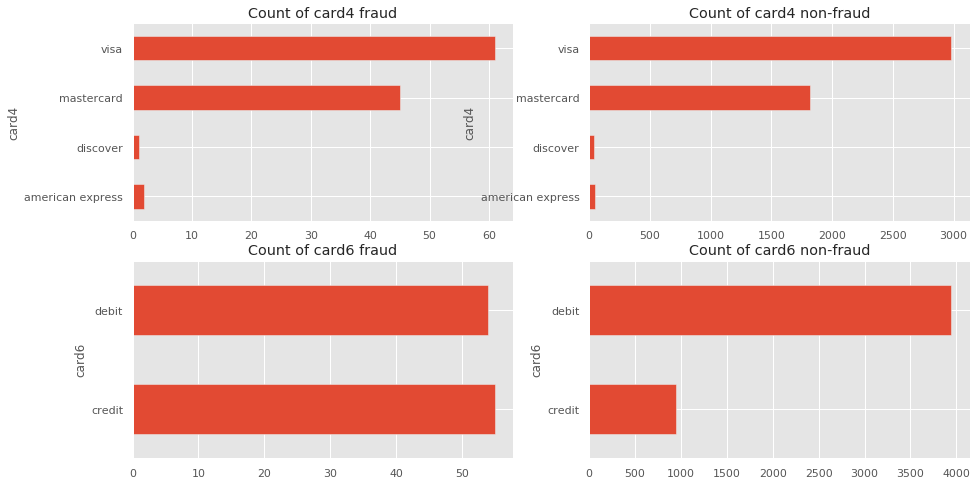

In [959]:
train_fr = train.loc[train['isFraud'] == 1]
train_nofr = train.loc[train['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

## DeviceType

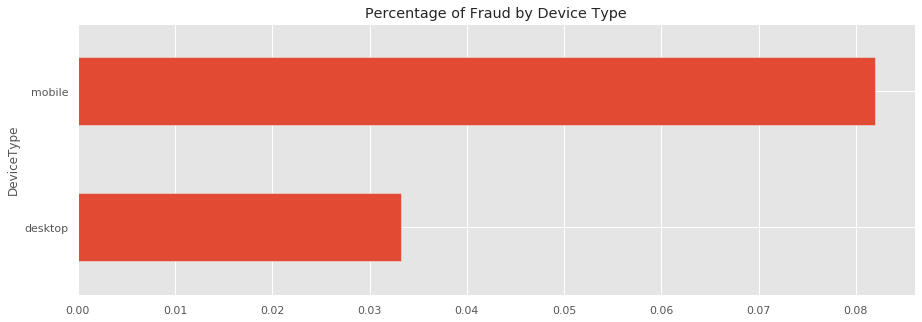

In [960]:
train.groupby('DeviceType') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type')
plt.show()

## DeviceInfo

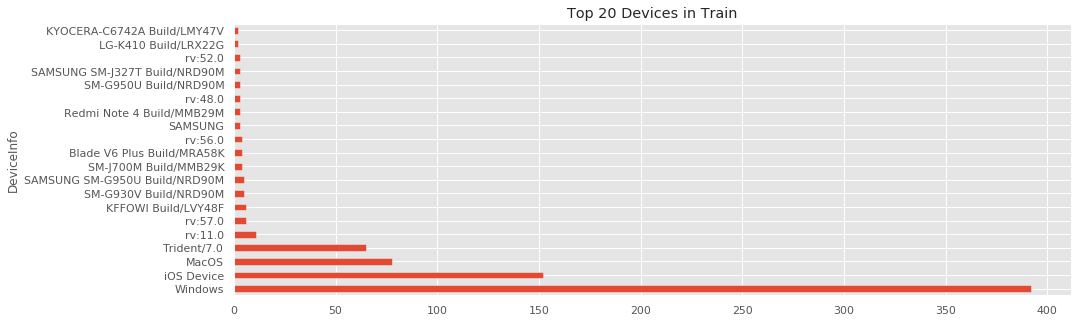

In [961]:
train.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()

## TransactionDT

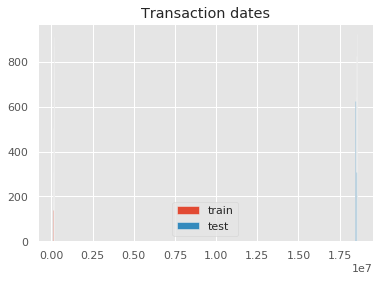

In [962]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Transaction dates');

Ci-dessus, on voit que les dates des données Train et Test ont une intersection vide.

In [963]:
y_train = train.isFraud
train = train.drop(['isFraud', 'TransactionID'],axis= 1)
transactionIDTest = test['TransactionID']
test = test.drop('TransactionID', axis= 1)
train.shape, test.shape

((5000, 432), (5000, 432))

# Valeurs manquantes

**Nettoyage des NaN**

**Train**

In [964]:
missing_values_count = train.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionDT       0
TransactionAmt      0
ProductCD           0
card1               0
card2              75
card3               0
card4               0
card5               9
card6               0
addr1             393
dtype: int64
% of missing data =  50.96319444444445


On peut voir que 45% des données du train sont des valeurs manquantes, nettoyons tout ça !

In [965]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.9156
0.0    0.0788
3.0    0.0020
1.0    0.0014
2.0    0.0012
Name: id_03, dtype: float64

 - On supprime les variables qui ont plus de 80% de NA

In [966]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.8]
    return many_null_cols

In [967]:
null_cols = get_too_many_null_attr(train)
train.drop(null_cols,1,inplace=True)

In [968]:
def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

On peut voir que 88% des données sont des NaN, et 10% sont des valeurs nulles. Soit 98% des données sont des valeurs manquantes, donc inutiles !

On sépare les variables qualitatives et quantitatives : 

In [969]:
mask1 = train.dtypes==object
categoricalColumns = train.columns[mask1]
categoricalFeatures = train[categoricalColumns]
categoricalFeatures.head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [970]:
mask2 = train.dtypes!=object
numericalColumns = train.columns[mask2]
numericalFeatures = train[numericalColumns]
numericalFeatures.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,1.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,2.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Corrélations entre les variables numériques

In [1]:
"""
correlations = numericalFeatures[['id_01','id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(categoricalFeatures)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations
"""

"\ncorrelations = numericalFeatures[['id_01','id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20']].corr()\nfig = plt.figure()\nax = fig.add_subplot(111)\ncax = ax.matshow(correlations, vmin=-1, vmax=1)\nfig.colorbar(cax)\nnames = ['']+list(categoricalFeatures)\nax.set_xticklabels(names)\nax.set_yticklabels(names)\nplt.show()\ncorrelations\n"

In [2]:
"""correlations = numericalFeatures[['TransactionAmt','TransactionDT','card2','card3','card5']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(categoricalFeatures)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations"""

"correlations = numericalFeatures[['TransactionAmt','TransactionDT','card2','card3','card5']].corr()\nfig = plt.figure()\nax = fig.add_subplot(111)\ncax = ax.matshow(correlations, vmin=-1, vmax=1)\nfig.colorbar(cax)\nnames = ['']+list(categoricalFeatures)\nax.set_xticklabels(names)\nax.set_yticklabels(names)\nplt.show()\ncorrelations"

On remarque qu'il n'y a pas de corrélations entre les variables.

 - Normalisation des variables numériques : 
 
 $\frac{X - \mu}{\sigma}$, avec $\mu$ : la moyenne de X et $\sigma$ : l'écart-type de X.

In [973]:
numericalFeatures = (numericalFeatures-numericalFeatures.mean())/numericalFeatures.std()

In [974]:
numericalFeatures.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,-2.137688,-0.308105,0.882855,NaN,-0.259521,-1.503906,0.212769,0.0,-0.292725,-0.196777,...,-0.226318,-0.163818,-0.215942,-0.186035,-0.120850,-0.000865,-0.120911,-0.109497,-0.162598,-0.121704
1,-2.137648,-0.466309,-1.471621,0.363525,-0.259521,-2.541016,0.309570,0.0,NaN,-0.196777,...,-0.226318,-0.163818,-0.215942,-0.186035,-0.120850,-0.090820,-0.120911,-0.109497,-0.162598,-0.121704
2,-2.134915,-0.346191,-1.069478,0.907715,-0.259521,-0.881836,0.357910,0.0,0.471924,-0.196777,...,-0.226318,-0.163818,-0.215942,-0.186035,-0.120850,-0.090820,-0.120911,-0.109497,-0.162598,-0.121704
3,-2.133710,-0.382080,1.769340,1.394531,-0.259521,-2.152344,1.770508,0.0,NaN,-0.172485,...,0.885254,-0.163818,-0.215942,-0.186035,0.042053,0.988281,1.551758,-0.109497,-0.162598,-0.121704
4,-2.133429,-0.382080,-1.104465,1.059570,-0.259521,-2.541016,1.228516,0.0,NaN,-0.196777,...,-0.226318,-0.163818,-0.215942,-0.186035,-0.120850,-0.090820,-0.120911,-0.109497,-0.162598,-0.121704


***If one feature has the same value, the new value after standardization will be equal to NaN. So, we will drop features which have NaN after normalization.***

In [975]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNullScaled = numericalFeatures.columns[nonNull]
columnNonNullScaled

Index(['card2', 'card5', 'addr1', 'addr2', 'dist1', 'D2', 'D3', 'D4', 'D5',
       'D10',
       ...
       'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V107', 'V117',
       'V305'],
      dtype='object', length=109)

In [976]:
numericalFeatures = numericalFeatures.drop(columnNonNullScaled, axis = 1)

In [977]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNull = numericalFeatures.columns[nonNull]
columnNonNull

Index([], dtype='object')

In [978]:
numericalFeatures.columns

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card3', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=102)

***Test dataset cleaning*** 

***First time, we rename column name of test dataset: We replace - by _***

In [979]:
droppedColumnsTest = []
for i in test.columns:
  a = i.replace('-','_')
  droppedColumnsTest.append(a)
test.columns = droppedColumnsTest

***Extracting categorical and numerical features***

In [980]:
X_testCategorical = test[categoricalFeatures.columns]

In [981]:
X_testNumerical  = test[numericalFeatures.columns]

***Removing Nan of numerical features.***

In [982]:
null_cols = get_too_many_null_attr(X_testNumerical)
X_testNumerical.drop(null_cols,1,inplace=True)

***We verify if the categorical features of training and test set have the same number of unique value before encoding*** 

In [983]:
categoricalFeatures.describe()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,5000,5000,5000,3894,2136,2136,2136,2498,2109,3824,1134,1134,1134
unique,5,4,2,43,1,2,2,3,2,2,2,2,2
top,W,visa,debit,gmail.com,T,T,T,M0,F,F,F,F,T
freq,3971,3044,4001,1816,2136,1920,1647,1762,1133,2164,956,702,949


In [984]:
X_testCategorical.describe()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,5000,4999,5000,4180,3983,3983,3983,2409,2082,4213,3499,3500,3500
unique,5,4,2,48,1,2,2,3,2,2,2,2,2
top,W,visa,debit,gmail.com,T,T,T,M0,F,F,F,F,T
freq,4361,3324,4046,2055,3983,3678,3249,1576,1140,2230,2980,2113,3026


***We remark that some categorical features have different unique value in training and test set. That will lead to different shape of training and test sets. We decide to remove these features.***

***Categorical features with different value***

In [985]:
A = []
for i in X_testCategorical.columns:
  if len(X_testCategorical[i].value_counts()) != len(categoricalFeatures[i].value_counts()):
    A.append(i)
A

['P_emaildomain']

***Dropping these categorical features before encoding.***

In [986]:
categoricalFeatures = categoricalFeatures.drop(A, axis = 1)
X_testCategorical = X_testCategorical.drop(A, axis = 1)

## Les chaînes de caractères

Pour pourvoir utiliser les variables contenant des chaînes de caractères, on utilise la méthode de one hot encoder.
***We use get_dummies method to encode categorical features of training and test set.***

In [987]:
def encodingTrain():
  x = pd.get_dummies(categoricalFeatures, columns= categoricalFeatures.columns)
  return x.join(numericalFeatures) 

In [988]:
X_trainEncoded = encodingTrain()

In [989]:
def encodingTest():
  x = pd.get_dummies(X_testCategorical, columns= X_testCategorical.columns) 
  return x.join(X_testNumerical)

In [990]:
X_testEncoded = encodingTest()

***We verify the shape of training and test sets after encoding.***

In [991]:
X_trainEncoded.shape, X_testEncoded.shape, y_train.shape

((5000, 131), (5000, 131), (5000,))

***We verify if there is not Nan in training and test set after encoding.***

In [992]:
nonNull = X_trainEncoded.isnull().sum() != 0
columnNonNull = X_trainEncoded.columns[nonNull]
columnNonNull

Index([], dtype='object')

In [993]:
nonNull = X_testEncoded.isnull().sum() != 0
columnNonNull = X_testEncoded.columns[nonNull]
columnNonNull

Index(['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301',
       'V313', 'V314', 'V315'],
      dtype='object')

***We verify if columns name in training and test sets are the same.***

In [994]:
A = X_trainEncoded.columns == X_testEncoded.columns
A.sum() == len(X_trainEncoded.columns)

True

***The columns name in training and test set are the same Now, we will build the model which may avoid overfitting since we have a lof features.***

# Prédiction de la probabilité du nombre de fraudes

## Régression logistique

In [995]:
Y = y_train 
X = X_trainEncoded

#### Split nos données en train(67%) et test(33%)

In [996]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [997]:
def temps(second):
    m, s = divmod(second, 60)
    h, m = divmod(m, 60)
    print("temps :",'{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s))

### Regression logistique avec toutes nos variables 

In [998]:
tstart = time.time()
log = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_train = log.predict_proba(X_train)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

score auc train : 0.9101516292074416
temps : 00:00:00


In [999]:
tstart = time.time()
pred = log.predict_proba(X_test)
print("score auc test :",roc_auc_score(y_test, pred[:, 1]))
tend = time.time()
temps(tend-tstart)

score auc test : 0.7982537252345798
temps : 00:00:00


## Regression logistique avec cross validation

### cross validation sur toutes nos données

In [1000]:
tstart = time.time()
clf = LogisticRegression(random_state=0)
scores = cross_val_score(clf, X, Y, cv=5,scoring='roc_auc')
print("score auc :",scores)
tend = time.time()
temps(tend-tstart)

score auc : [0.6959792  0.73842722 0.7704499  0.78759993 0.73712143]
temps : 00:00:01


On peut constater que l'on obtient un auc de 0.919 qui est le plus élevé obtenu jusqu'à présent

In [1001]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sample = cross_val_score(clf, X, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sample)
tend = time.time()
temps(tend-tstart)

score auc : [0.77992386 0.75232385 0.79313069 0.82487451 0.74408414]
temps : 00:00:16


Les auc obtenu avec une penalty l1 sont bien meilleurs que ceux obtenus prédédement. Toutefois, nous travaillons que sur 60000 données. Le temps de d'exécution est en revanche bien plus grand avec cette méthodes.

## Cross validation pour le paramètre Inverse of regularization strength

### Données centrées réduites:

temps : 00:00:11


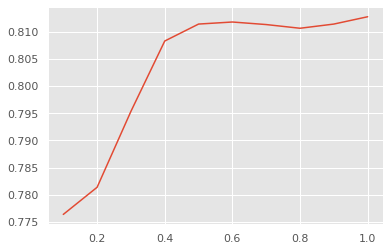

In [1002]:
pred = []
tstart = time.time()
t = np.arange(0.1,1.1,0.1)
for i in t:
    if(i%2==0): print(i)
    log = LogisticRegression(solver ='liblinear', penalty = 'l1', C=i, random_state=0).fit(X_train, y_train)
    pred_train = log.predict_proba(X_test)
    pred.append(roc_auc_score(y_test, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

plt.plot(t,pred)

In [1003]:
print("Pour C = ",t[np.argmax(pred)], " ,auc = ",np.max(pred))

Pour C =  1.0  ,auc =  0.8127908563112978


temps : 00:00:00


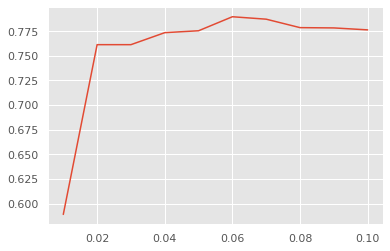

In [1004]:
pred = []
tstart = time.time()
t = np.arange(0.01,0.11,0.01)
for i in t:
    if((i*10)%2==0): print(i)
    log = LogisticRegression(solver ='liblinear', penalty = 'l1', C=i, random_state=0).fit(X_train, y_train)
    pred_train = log.predict_proba(X_test)
    pred.append(roc_auc_score(y_test, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

plt.plot(t,pred)

In [1005]:
print("Pour C = ",t[np.argmax(pred)], " ,auc = ",np.max(pred))

Pour C =  0.060000000000000005  ,auc =  0.7896890963937607


In [1006]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', C=0.03, penalty = 'l1', random_state=0)
scores_sub_sc = cross_val_score(clf, X, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_sc)
tend = time.time()
temps(tend-tstart)

score auc : [0.7886294  0.50450827 0.68200409 0.89809909 0.68787126]
temps : 00:00:00


In [1007]:
pred = []
tstart = time.time()
t = np.arange(0,1.1,0.1)
for i in t:
    if((i*10)%2==0): print(i)
    log = LogisticRegression(solver ='saga', penalty = 'elasticnet', random_state=0, l1_ratio=i).fit(X_train, y_train)
    pred_train = log.predict_proba(X_test)
    pred.append(roc_auc_score(y_test, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

0.0
0.2
0.4
0.8
1.0
temps : 00:00:07


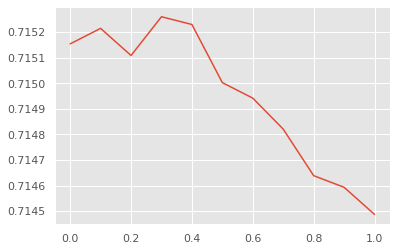

In [1008]:
plt.plot(t,pred)

essayer de melanger les données (toutes les données non fraude sont en haut et fraude en bas du DataFrame)
essayer avec : df = df.sample(frac=1).reset_index(drop=True)

In [1009]:
X_shuffle = X.join(Y.reset_index(drop=True))
X_shuffle = X_shuffle.sample(frac=1).reset_index(drop=True)

In [1010]:
Y_sh = X_shuffle["isFraud"]
X_sh = X_shuffle.loc[:, X_shuffle.columns != "isFraud"]

In [1011]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sh = cross_val_score(clf, X_sh, Y_sh, cv=5,scoring='roc_auc')
print("score auc :",scores_sh)
tend = time.time()
temps(tend-tstart)

score auc : [0.78788653 0.67891337 0.74514315 0.58605224 0.83778849]
temps : 00:00:00


# Selection de variables avec Lasso

### Variables sélectionner par Lasso pour  $\lambda$=1

In [1012]:
clf = linear_model.Lasso(alpha=1)
clf.fit(X,Y)


Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [1013]:
coef = clf.coef_
col_ohe = X.columns
var_ohe = col_ohe[coef!=0]
X_lasso = X[var_ohe]

In [1014]:
print(len(var_ohe))

0


Nous pouvons constater que la plupart des coefficients ont été mis à zéros

In [3]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

'tstart = time.time()\nclf = LogisticRegression(solver =\'liblinear\', penalty = \'l1\', random_state=0)\nscores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=5,scoring=\'roc_auc\')\nprint("score auc :",scores_sub_lasso)\ntend = time.time()\ntemps(tend-tstart)'

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=10,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

###  Variables sélectionner par Lasso pour $\lambda$ =0.1 

In [ ]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X,Y)

In [ ]:
coef = clf.coef_
col_ohe = X.columns

In [ ]:
var_ohe = col_ohe[coef!=0]
print(len(var_ohe))

Nous pouvons voir qu'en ce lambda le nombre de coefficient différents de ézéros à augmenter

In [ ]:
X_lasso = X[var_ohe]

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', C=0.04, penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', C=0.04, penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=10,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

### Variables sélectionner par Lasso pour  𝜆 =0.01

In [ ]:
clf = linear_model.Lasso(alpha=0.01)
clf.fit(X,Y)

In [ ]:
coef = clf.coef_
col_ohe = X.columns
var_ohe = col_ohe[coef!=0]
X_lasso = X[var_ohe]

In [ ]:
print(len(var_ohe))

Nous pouvons constater que le nombre de coefficients différents de zéros a encore augmenté

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=10,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

m = RandomForestClassifier(n_jobs=-1, n_estimators = 20)
m.fit(X_train, y_train)
print(roc_auc_score(y_test,m.predict_proba(X_test)[:,1] ))

In [ ]:
"""sample_submission['isFraud'] = m.predict_proba(X_test)[:,1]
sample_submission.to_csv('base_RF.csv')

my_submission = pd.DataFrame({'': test.Id, 'SalePrice': predicted_prices})

my_submission.to_csv('submission.csv', index=False)
"""

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(roc_auc_score(y_test,gnb.predict_proba(X_test)[:,1] ))

***B) Modelling: Training and probability prediction***

***First time, we tried KNN, but it appears that it is uncomfortable. Time exécution is great and it can lead to overfitting. One decides to use ensamble model, precisely adaptative boosting algorithm.***
 

***Adaptive Boosting model***

***Optimization of hyperparameters***

In [ ]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 1]}
gridCv = GridSearchCV(AdaBoostClassifier(), param_grid= parameters, cv=3, scoring='roc_auc')

In [ ]:
begin = time.time()
gridCv.fit(X,Y)
end = time.time()

***a) Time of execution for optimizing hyperparameters***

In [ ]:
print("Time execution for optimizing hyperparapeter is {a} minutes.".format(a =(end-begin)/60))

***b)Best parameters, best estimator and best auc_ roc score***

In [ ]:
gridCv.best_params_

In [ ]:
gridCv.best_estimator_

In [ ]:
gridCv.best_score_

***1) Adaboost Model with all features (and best parameters)***

In [ ]:
Model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=50, random_state=None)

In [ ]:
Model.fit(X,Y)

***Probability predicted by the model***

In [ ]:
predictedProba1 = pd.DataFrame(Model.predict_proba(X_test), columns=['0','1'])


In [ ]:
fraudTransaction = predictedProba1['1']
nonFraudTransaction = predictedProba1['0']

***Let's write function for save predicted probability in cvs file***

In [ ]:
def saveCSV(predictedProba, filename="submission.csv"):
    pd.Series(predictedProba).to_csv(filename, index=False)

In [ ]:
predictedProbaFraud = saveCSV(fraudTransaction, "predictedProbaFraud.csv")
predictedProbaNonFraud = saveCSV(nonFraudTransaction, "predictedProbaNonFraud.csv")

***2) Adaboost Model with only important features (and best parameters)***

***The method feature_importances_ is used to get out important features.***

In [ ]:
importantFeature = []
importantFeatureName = []
for feat, importance in zip(X.columns, gridCv.best_estimator_.feature_importances_):
  if importance!= 0:
      importantFeature.append(importance)
      importantFeatureName.append(feat)
      print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

***Training and test set with only important features***

In [ ]:
X_trainEncodedBest = X_train[importantFeatureName]
X_testEncodedBest = X_test[importantFeatureName]

In [ ]:
begin = time.time()
crossValScore = cross_val_score(Model, X_trainEncodedBest, y_train, cv= 3, scoring='roc_auc')
end = time.time()

In [ ]:
print("auc score is: {f}".format(f=np.mean(crossValScore)))
print("Time exécution is {a} minutes".format(a = (end-begin)/60))

***Probability of fradulent transaction predicted by our best model***

In [ ]:
predictedProba2 = pd.DataFrame(bestModel.predict_proba(X_test), columns=['0','1'])

In [ ]:
fraudTransaction = predictedProba['1']
nonFraudTransaction = predictedProba['0']

In [ ]:
fraudTransaction.index = transactionIDTest
nonFraudTransaction.index = transactionIDTest

In [ ]:
fraudTransaction.head()

In [ ]:
nonFraudTransaction.head()

In [ ]:
predictedProbaFraud1 = saveCSV(fraudTransaction, "predictedProbaFraud1.csv")
predictedProbaNonFraud1 = saveCSV(nonFraudTransaction, "predictedProbaNonFraud1.csv")

***Conclusion: Our model using all features takes a lot time, but gives best auc_score (0.88) while with only import features, we got 0.8 auc_score. We can explore the model with important features in order to improve auc_score since it takes few time for execution.*** 